# Concept pair appearance comparison between Mark2Cure and SemmedDB

This module inspects pulls the completed concept pairs for each pmid, determines the majority response, counts the number of pmids each concept pair appears in, and then checks SemmedDB for the appearance of the concept pairs either together (ie- in a relationship) or separately (ie- co-mention, but not related). The counts are visualized for easy comparison. To limit the amount of data processed, the concept pairs are restricted to only those that were quality checked. Since SemmedDB may not necessarily have both concept pairs in a relationship for that PMID, the pmids in which each QC'd concept pair appeared (regardless as to whether it was the one that was actually QC'd) was pulled and used to filter SemmedDB. In other words, these PMID's should have the concept pairs in them even if SemmedDB doesn't show them having a relationship. For each PMID in this set, the SemmedDB concepts were pulled and filtered for Mark2Cure semantic types. Each QC'd concept pair was then checked for appearance of that exact pair as a relationship annotation in SemmedDB, or as just being present as individual concepts in that PMID. Note that identifiers are used for mapping so concepts which were not mapped to MeSH IDs or entrez gene ids dropped out (hence eliminating the filter for Mark2Cure semantic types, would not change the results).


## Import modules and data

In [1]:
import pandas
import matplotlib
from matplotlib import pyplot as mplot
from matplotlib import patches as mpatches
import m2c_rel_basic
from pandas import read_csv

In [2]:
savepath = 'data/'
exppath = 'results/'
all_completed_anns = read_csv(exppath+'annresults.txt', delimiter='\t', header=0)
all_completed_anns['refid1_type']= all_completed_anns['reltype'].astype(str).str[0]
all_completed_anns['refid2_type']= all_completed_anns['reltype'].astype(str).str[2]
all_completed_anns.drop("Unnamed: 0",axis=1,inplace=True)
print('Number of relationship annotations for completed RE tasks: ',len(all_completed_anns))
all_completed_id_anns= all_completed_anns.loc[(all_completed_anns['refid1']!='None')&
                                              (all_completed_anns['refid2']!='None')].copy()
print('Relationship annotations for only concepts that have identifiers: ',len(all_completed_id_anns))
print('Unique concept pairs regardless of pmid: ',len(set(all_completed_anns['concept_pair'].tolist())))

Number of relationship annotations for completed RE tasks:  2950
Relationship annotations for only concepts that have identifiers:  2846
Unique concept pairs regardless of pmid:  619


In [3]:
## Import the list of all QC'd cpmids
esample_df = m2c_rel_basic.get_QC_data(savepath)

## drop the annotations marked 'broken'
expert_not_broken = esample_df.loc[(esample_df['conclusion']!='c1_broken')&(esample_df['conclusion']!='c2_broken')]
#print(expert_not_broken.head(n=2))
print(len(expert_not_broken))

69


In [4]:
#import semmeddb mapped to MeSH
semmed_merged = pandas.read_csv(exppath+'semmed_merged.txt',delimiter='\t',header=0)
semmed_merged.drop("Unnamed: 0",axis=1,inplace=True)
print(semmed_merged.head(n=2))

  SUBJECT_NAME    PREDICATE    OBJECT_NAME     PMID SUBJECT_CUI  \
0     Membrane  LOCATION_OF  Cytochromes b  3305576    C0596901   
1  granulocyte      PART_OF          Human  3305576    C0018183   

  SUBJECT_SEMTYPE OBJECT_CUI OBJECT_SEMTYPE  PREDICATION_ID  SENTENCE_ID  \
0            celc   C0010744           aapp         7613702     15005034   
1            cell   C0020114           humn         7613765     15005153   

   SUBJECT_NOVELTY  OBJECT_NOVELTY SUBJECT_M2C_TYPE OBJECT_M2C_TYPE  \
0                1               1             celc            gene   
1                1               1             cell            humn   

  SUBJECT_ID OBJECT_ID  
0   notfound   D045303  
1    D006098  notfound  


In [5]:
#### Obtain the majority response for each concept pair
all_completed_id_anns.sort_values(['pmid','concept_pair','response_ratio'], ascending=[True,True,True],inplace=True)
majority_result = all_completed_id_anns.drop_duplicates(subset=('pmid','concept_pair'), keep='last')
print("Majority response, no duplicates: ", len(majority_result))

#### Pull the unique cpmids for which the majority response was NOT concept broken
not_broken = majority_result.loc[(majority_result['evtype']!='c_1_broken')&(majority_result['evtype']!='c_2_broken')]
print("Majority response is not broken: ", len(not_broken))

#### Also pull the unique cpmids for which the majority response was NOT related
not_unrelated = not_broken.loc[~not_broken['evtype'].str.contains('no relation')]
print('relations left after unrelated concepts removed: ',len(not_unrelated))
#print(M2C_semmed_merge.head(n=2))

Majority response, no duplicates:  975
Majority response is not broken:  531
relations left after unrelated concepts removed:  456


In [6]:
#### identify most frequent concept_pairs, the majority response, and map to the expert response
### Relationship between concept pairs can vary depending on abstract
### get counts of concept pairs with their relationships
cp_response_counts = majority_result.groupby(['concept_pair','evtype','reltype','refid1','refid2',
                                         'refid1_type','refid2_type']).size().reset_index(name='cp_res_count')
print('number of majority-response-specific cpmids: ',
      len(cp_response_counts))
### Now just get a count of the cpmids
cp_counts = majority_result.groupby(['concept_pair','reltype','refid1','refid2',
                                         'refid1_type','refid2_type']).size().reset_index(name='cp_count')

print('number of cpmids regardless of response: ',
      len(cp_counts))
### Sort the cps to get the most frequent concept pairs
cp_counts.sort_values('cp_count', ascending=False, inplace=True)
cp_response_counts.sort_values('cp_res_count', ascending=False, inplace=True)


### Filter for the cpmids that have been QC'd
exp_list = esample_df['concept_pair'].unique().tolist()
print('number of unique concept pairs that have been qc-d: ',
      len(exp_list))

qc_cp_ct = cp_counts.loc[cp_counts['concept_pair'].isin(exp_list)]
print('number of concept pairs in the majority response set that showed up in the qc-d set: ',
      len(qc_cp_ct))

qc_cp_res_ct = cp_response_counts.loc[cp_response_counts['concept_pair'].isin(exp_list)]
print('number of response-specific concept pairs that showed up in the qc-d set: ',
      len(qc_cp_res_ct))

qc_all = majority_result.loc[majority_result['concept_pair'].isin(exp_list)].copy()
qc_all_pmids = qc_all['pmid'].unique().tolist()
print('number of concept pairs with majority responses which showed up in the qc-d set: ',
      len(qc_all))
print('number of pmids which encompass those concept pairs which showed up in the qc-d set: ',
      len(qc_all_pmids))

number of majority-response-specific cpmids:  625
number of cpmids regardless of response:  590
number of unique concept pairs that have been qc-d:  92
number of concept pairs in the majority response set that showed up in the qc-d set:  82
number of response-specific concept pairs that showed up in the qc-d set:  103
number of concept pairs with majority responses which showed up in the qc-d set:  353
number of pmids which encompass those concept pairs which showed up in the qc-d set:  109


In [7]:
### Get the pmids where the qc'd cps appear, filter semmeddb set by those pmids
pmid_constraints = majority_result['pmid'].loc[majority_result['concept_pair'].isin(qc_cp_res_ct['concept_pair'].unique().tolist())].unique().tolist()
print('number of pmids which encompass the number of concept pairs which showed up in the qc-d set available in semmeddb: ', len(pmid_constraints))

sem_same_pmids = semmed_merged.loc[semmed_merged['PMID'].isin(pmid_constraints)]
sem_same_pmids.drop_duplicates(subset=['PMID','SUBJECT_CUI','SUBJECT_SEMTYPE','OBJECT_CUI','OBJECT_SEMTYPE',
                                      'PREDICATION_ID','SENTENCE_ID'], keep='first',inplace=True)
print('number of semmed relationships in those pmids: ',len(sem_same_pmids))

number of pmids which encompass the number of concept pairs which showed up in the qc-d set available in semmeddb:  109
number of semmed relationships in those pmids:  653


C:\Users\ginger\Anaconda3\envs\py3bioc\lib\site-packages\pandas\util\decorators.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return func(*args, **kwargs)


In [8]:
##### Working with this more restricted data set filter by M2C semantic types
### check the concept pairs in semmedDB to see how many pmids have both concepts
### vs how many actually have relationships in semmeddb

### Remove relationships if any of the semantics types in semmed db are NOT genes, disease, or treatment

semmed_m2c_types_only = sem_same_pmids.loc[((sem_same_pmids['SUBJECT_M2C_TYPE']=='gene')|
                                            (sem_same_pmids['SUBJECT_M2C_TYPE']=='disease')|
                                            (sem_same_pmids['SUBJECT_M2C_TYPE']=='treatment')) &
                                            ((sem_same_pmids['OBJECT_M2C_TYPE']=='gene')|
                                            (sem_same_pmids['OBJECT_M2C_TYPE']=='disease')|
                                            (sem_same_pmids['OBJECT_M2C_TYPE']=='treatment'))].copy()
#print('number of semmed relationships which left when restricted to M2C semantic types: ', len(semmed_m2c_types_only))
#print(semmed_m2c_types_only)

#### Convert all concepts to concept pairs (reverse concept pair as well) and compare the concept pairs

## create reverse concept pair in 'not broken' concept pairs from the 
qc_all['cp_reverse'] = qc_all['refid2'].astype(str).str.cat(qc_all['refid1'].astype(str),sep='_x_')

## Do the same for semmed cps
semmed_m2c_types_only['concept_pair'] = semmed_m2c_types_only['SUBJECT_ID'].astype(str).str.cat(semmed_m2c_types_only['OBJECT_ID'].astype(str),sep='_x_')
semmed_m2c_types_only['cp_reverse'] = semmed_m2c_types_only['OBJECT_ID'].astype(str).str.cat(semmed_m2c_types_only['SUBJECT_ID'].astype(str),sep='_x_')
semmed_m2c_types_only.rename(columns={'PMID':'pmid'}, inplace=True)

####Use merging to find concept pairs in common
forward_checklist = qc_all[['pmid','concept_pair']]
reverse_checklist = qc_all[['pmid','cp_reverse']]
reverse_checklist.rename(columns={'cp_reverse':'concept_pair'},inplace=True)
sem_to_chklist = semmed_m2c_types_only[['pmid','concept_pair']]
sem_fro_chklist = semmed_m2c_types_only[['pmid','cp_reverse']]
sem_fro_chklist.rename(columns={'cp_reverse':'concept_pair'},inplace=True)
forward_match = forward_checklist.merge(sem_to_chklist, on=('pmid','concept_pair'), how='inner')
for_fro_match = forward_checklist.merge(sem_fro_chklist, on=('pmid','concept_pair'), how='inner')
rev_to_match = reverse_checklist.merge(sem_to_chklist, on=('pmid','concept_pair'), how='inner')

## Check mechanism: if the forward matches, the reverse should match too
reverse_match = reverse_checklist.merge(sem_fro_chklist, on=('pmid','concept_pair'), how='inner')

print(len(forward_match),len(reverse_match),len(for_fro_match),len(rev_to_match))
print(forward_match)


3 3 0 0
       pmid    concept_pair
0  16528113   351_x_D000309
1  16609705  8086_x_D000309
2  23056690  8086_x_C536008


C:\Users\ginger\Anaconda3\envs\py3bioc\lib\site-packages\pandas\core\frame.py:2834: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [9]:
#### From the pmid-constrained, m2C semantic type constrained SemmedDB data, look for heterotype relationships

heterorels = semmed_m2c_types_only.loc[semmed_m2c_types_only['SUBJECT_M2C_TYPE']!=semmed_m2c_types_only['OBJECT_M2C_TYPE']]
print(len(heterorels))
heterorels_pmids = heterorels.groupby('pmid').size().reset_index(name='counts')
print(len(heterorels_pmids))

89
45


In [10]:
##### Working only with concept pairs in the QC'd in case reviews of the cps are needed,
#### count the number of pmids for which:
### a specific relationship is given
### a broad relationship is given
### 'no relationship' is selected

#print(qc_nb.head(n=2))
#print(qc_cp_res_ct.head(n=2))
cpair_list = qc_cp_ct['concept_pair'].unique().tolist()
relation_count_list = []

for eachcp in cpair_list:
    restypecounts = 0
    tmpdf = qc_cp_res_ct.loc[qc_cp_res_ct['concept_pair']==eachcp]
    tmpdf2 = qc_cp_ct.loc[qc_cp_ct['concept_pair']==eachcp]
    total_pmids = tmpdf2['cp_count'].iloc[0]
    tmpdict = {'concept_pair':eachcp, 'total_pmids':total_pmids, 'broad_rel':0,'spec_rel':0, 'no_rel':0, 'cp_broken':0}
    if len(tmpdf) == 1:
        ## Majority ruled across different documents, the relationship is the same
        if 'relates to' in tmpdf['evtype'].iloc[0]:
            tmpdict['broad_rel'] = tmpdf['cp_res_count'].iloc[0]
        elif 'no relation' in tmpdf['evtype'].iloc[0]:
            tmpdict['no_rel'] = tmpdf['cp_res_count'].iloc[0]
        elif 'broken' in tmpdf['evtype'].iloc[0]:
            tmpdict['cp_broken'] = tmpdf['cp_res_count'].iloc[0]
        else:
            tmpdict['spec_rel'] = tmpdf['cp_res_count'].iloc[0]
        relation_count_list.append(tmpdict)
        
    else: 
        ## Majority ruled there is more than one type of relationship depending on document
        no_rel = tmpdf.loc[tmpdf['evtype'].astype(str).str.contains('no relation')]
        broad_rel = tmpdf.loc[tmpdf['evtype'].astype(str).str.contains('relates to')]
        cp_broken_rel = tmpdf.loc[tmpdf['evtype'].astype(str).str.contains('broken')]
        spec_rel = tmpdf.loc[~tmpdf['evtype'].astype(str).str.contains('relates to')&
                             ~tmpdf['evtype'].astype(str).str.contains('no relation')&
                             ~tmpdf['evtype'].astype(str).str.contains('broken')]
        try:
            tmpdict['spec_rel'] = spec_rel['cp_res_count'].iloc[0]
        except:
            restypecounts = restypecounts+1
        try:
            tmpdict['broad_rel'] = broad_rel['cp_res_count'].iloc[0]
        except:
            restypecounts = restypecounts+1
        try:
            tmpdict['no_rel'] = no_rel['cp_res_count'].iloc[0]
        except:
            restypecounts = restypecounts+1
        try:
            tmpdict['cp_broken'] = cp_broken_rel['cp_res_count'].iloc[0]
        except:
            restypecounts = restypecounts+1
        relation_count_list.append(tmpdict)

m2c_relation_cts = pandas.DataFrame(relation_count_list)
print(m2c_relation_cts.head(n=2))
#m2c_relation_cts.to_csv(exppath+'figure_6_sample_data.txt',sep='\t',header=True)

   broad_rel    concept_pair  cp_broken  no_rel  spec_rel  total_pmids
0          0  8086_x_C536008          3       0        33           36
1          0  8086_x_C536009          0       0        32           32


In [11]:
supplemental_tbl1 = majority_result.merge(m2c_relation_cts,on='concept_pair',how='left')

supplemental_tbl1.sort_values('total_pmids', ascending=False, inplace=True)
#supplemental_tbl1.to_csv(exppath+'supplemental_tbl1.txt',sep='\t',header=True)
print(supplemental_tbl1.head(n=2))

         pmid refid1   refid2 reltype    concept_pair  user_count  \
244  12717251   8086  C536008     g_d  8086_x_C536008          16   
774  22584989   8086  C536008     g_d  8086_x_C536008          15   

                                              evtype  relation_count  \
244  gene mutation is/may be associated with disease              16   
774  gene mutation is/may be associated with disease              11   

     test_completions  true_responses  response_ratio refid1_type refid2_type  \
244               0.0              16        1.000000           g           d   
774               0.0              15        0.733333           g           d   

     broad_rel  cp_broken  no_rel  spec_rel  total_pmids  
244        0.0        3.0     0.0      33.0         36.0  
774        0.0        3.0     0.0      33.0         36.0  


In [12]:
#### Create a concept map table
cp1_df = sem_same_pmids[['PMID','SUBJECT_ID']].rename(columns={'SUBJECT_ID':'cpid','PMID':'pmid'})
cp2_df = sem_same_pmids[['PMID','OBJECT_ID']].rename(columns={'OBJECT_ID':'cpid','PMID':'pmid'})
cpmaptbl = pandas.concat((cp1_df,cp2_df))
cpmaptbl.drop_duplicates(subset=['pmid','cpid'],keep='first',inplace=True)
#print(cpmaptbl)
#print(sem_same_pmids.head(n=10))
print(len(cpmaptbl))

773


In [13]:
#### for each concept pair, check the number of pmids that both pairs appear in
cp_appear_list = []
for eachcp in cpair_list:
    cpset = eachcp.split('_x_')
    try:
        cp1_pmids = set(cpmaptbl['pmid'].loc[cpmaptbl['cpid']==str(cpset[0])].unique().tolist())
    except:
        print('cp1 not found')
    try:
        cp2_pmids = set(cpmaptbl['pmid'].loc[cpmaptbl['cpid']==str(cpset[1])].unique().tolist())
    except:
        print('cp2 not found')
#    print(eachcp, cp1_pmids, cp2_pmids)
    both_cp_pmids = cp1_pmids.intersection(cp2_pmids)
    tmpdict = {'concept_pair':eachcp,'sem_pmid_cts':len(both_cp_pmids),'sem_pmid_list':both_cp_pmids}
    cp_appear_list.append(tmpdict)
semmed_cp_appear_only = pandas.DataFrame(cp_appear_list)
#print(semmed_cp_appear_only.head(n=10))

In [14]:
#### Merge the concept pairs that DO appear in SemmedDB
semmed_true_cps = []
semmed_true_cp_list = forward_match['concept_pair'].tolist()
for eachcpair in semmed_true_cp_list:
    tmpdf = forward_match.loc[forward_match['concept_pair']==eachcpair]
    pmids = set(tmpdf['pmid'].unique().tolist())
    tmpdict = {'concept_pair':eachcpair,'sem_tpmid_list':pmids,'sem_true_cp_ct':len(pmids)}
    semmed_true_cps.append(tmpdict)    
semmed_true_cps_df = pandas.DataFrame(semmed_true_cps)
#print(semmed_true_cps_df)
semmed_cp_appear_df = semmed_cp_appear_only.merge(semmed_true_cps_df, on='concept_pair',how='left').fillna(0)
print(semmed_cp_appear_df.head(n=2))

     concept_pair  sem_pmid_cts  \
0  8086_x_C536008             5   
1  8086_x_C536009             0   

                                       sem_pmid_list sem_tpmid_list  \
0  {20051279, 23056690, 17880786, 16938764, 21565...     {23056690}   
1                                                 {}              0   

   sem_true_cp_ct  
0             1.0  
1             0.0  


C:\Users\ginger\Anaconda3\envs\py3bioc\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


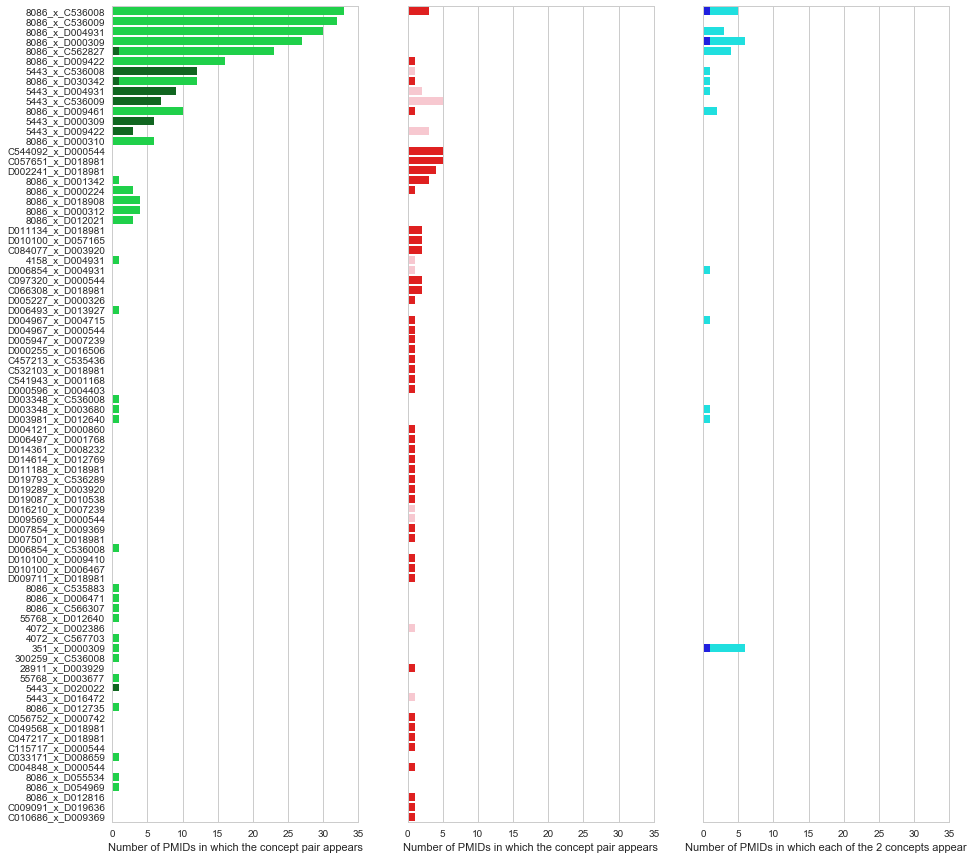

In [15]:
import seaborn as sns
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f = mplot.figure(figsize=(15,15))

# Plot the specific relationships involved
ax = mplot.subplot(1,3,1)
sns.set_color_codes("bright")
ax.yaxis.set_visible(True)
ax.xaxis.set_visible(True)
ax = sns.barplot(x="spec_rel", y="concept_pair", data=m2c_relation_cts,
            label="Specific relationships", color="g")

# Plot the broad relationships  involved
sns.set_color_codes("dark")
sns.barplot(x="broad_rel", y="concept_pair", data=m2c_relation_cts,
            label="Broad relationships", color="g")

ax.set(xlim=(0, 35), ylabel="",
       xlabel="Number of PMIDs in which the concept pair appears")

## Plot the broken and unrelated relationships
ax2 = mplot.subplot(1,3,2)
ax2.yaxis.set_visible(False)
ax2.xaxis.set_visible(True)
sns.set_color_codes("pastel")
ax2 = sns.barplot(x="cp_broken", y="concept_pair", data=m2c_relation_cts,
            label="concept broken", color="red")

sns.set_color_codes("bright")
sns.barplot(x="no_rel", y="concept_pair", data=m2c_relation_cts,
            label="no relation", color="pink")

ax2.set(xlim=(0, 35), ylabel="",
       xlabel="Number of PMIDs in which the concept pair appears")

# Plot the number of PMIDs in which both concepts were found in that pmid
sns.set_color_codes("muted")
ax3 = mplot.subplot(1,3,3)
ax3.yaxis.set_visible(False)
ax3.xaxis.set_visible(True)
ax3 = sns.barplot(x="sem_pmid_cts", y="concept_pair", data=semmed_cp_appear_df,
            label="concepts appear in SemmedDB", color="cyan")

sns.barplot(x="sem_true_cp_ct", y="concept_pair", data=semmed_cp_appear_df,
            label="concept pair appears in semmedDB", color="blue")

ax3.set(xlim=(0, 35), ylabel="",
       xlabel="Number of PMIDs in which each of the 2 concepts appear")

# Add a legend and informative axis label
#f.legend(ncol=2, loc="lower center", frameon=True)
#sns.despine(left=True, bottom=True)
mplot.show()
#mplot.savefig(exppath+'relationship_distribution_three.png', bbox_inches='tight', dpi=300)

C:\Users\ginger\Anaconda3\envs\py3bioc\lib\site-packages\ipykernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


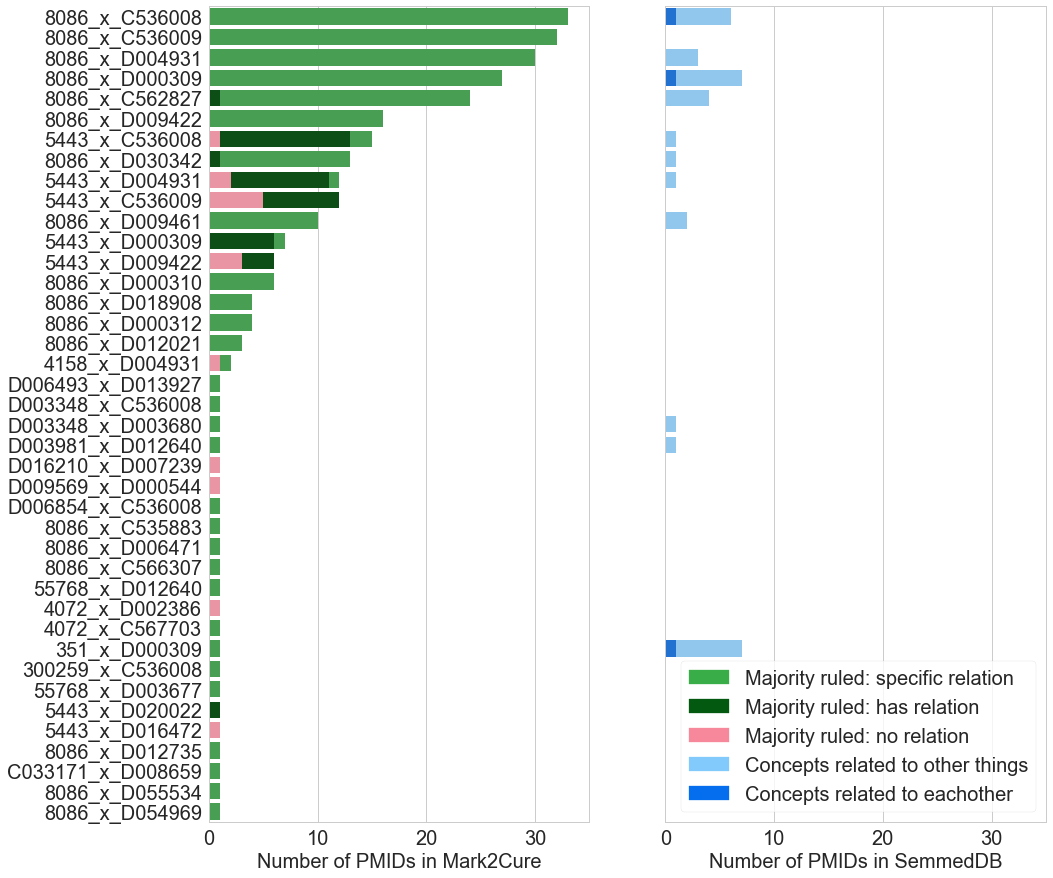

In [21]:
#### Remove the pairs where majority ruled that the concept was broken
#### Add back in pairs where concept broken was chosen by the majority in <15% of the papers
#### Plot 'no relation' responses with Specific and broad relationships
#### Reduce figure to 2 plots instead of 3---one for Mark2Cure, one for SemmedDB
m2c_relation_cts_no_broken = m2c_relation_cts.loc[(m2c_relation_cts['cp_broken']==0) | (m2c_relation_cts['cp_broken'] <= (m2c_relation_cts['total_pmids'])*0.15)].copy()
m2c_relation_cts_no_broken['total_stack'] = m2c_relation_cts_no_broken['spec_rel']+m2c_relation_cts_no_broken['no_rel']+m2c_relation_cts_no_broken['broad_rel']
m2c_relation_cts_no_broken['broad_stack'] = m2c_relation_cts_no_broken['no_rel']+m2c_relation_cts_no_broken['broad_rel']
cps_to_keep=m2c_relation_cts_no_broken['concept_pair'].tolist()
semmed_cp_appear_df_kept = semmed_cp_appear_df.loc[semmed_cp_appear_df['concept_pair'].isin(cps_to_keep)]
semmed_cp_appear_df_kept['total'] = semmed_cp_appear_df_kept['sem_pmid_cts']+semmed_cp_appear_df_kept['sem_true_cp_ct']

# Initialize the matplotlib figure
f = mplot.figure(figsize=(15,15))

# Plot the specific relationships involved
ax = mplot.subplot(1,2,1)
#sns.set_color_codes("bright")
ax.yaxis.set_visible(True)
ax.xaxis.set_visible(True)
ax = sns.barplot(x="total_stack", y="concept_pair", data=m2c_relation_cts_no_broken,
            label="Majority ruled: specific relation", color=sns.xkcd_rgb['medium green'])

# Plot the broad relationships  involved
#sns.set_color_codes("dark")
sns.barplot(x="broad_stack", y="concept_pair", data=m2c_relation_cts_no_broken,
            label="Majority ruled: has relation", color=sns.xkcd_rgb['deep green'])

# Plot the unrelated relationships
#sns.set_color_codes("bright")
sns.barplot(x="no_rel", y="concept_pair", data=m2c_relation_cts_no_broken,
            label="Majority ruled: no relation", color=sns.xkcd_rgb['rose pink'])

ax.set(xlim=(0, 35))
ax.set_xlabel("Number of PMIDs in Mark2Cure",fontsize=20)
ax.set_ylabel("")
ax.tick_params(labelsize=20)

# Plot the number of PMIDs in which both concepts were found in that pmid
#sns.set_color_codes("muted")
ax2 = mplot.subplot(1,2,2)
ax2.yaxis.set_visible(False)
ax2.xaxis.set_visible(True)
ax2 = sns.barplot(x="total", y="concept_pair", data=semmed_cp_appear_df_kept,
            label="concepts related to other things", color=sns.xkcd_rgb['sky'])

sns.barplot(x="sem_true_cp_ct", y="concept_pair", data=semmed_cp_appear_df_kept,
            label="concepts related to eachother", color=sns.xkcd_rgb['cerulean blue'])

ax2.set(xlim=(0, 35))
ax2.set_xlabel("Number of PMIDs in SemmedDB",fontsize=20)
ax2.set_ylabel("")
ax2.tick_params(labelsize=20)

### Add a legend and informative axis label
## Create artist proxy
mg_patch = mpatches.Patch(color=sns.xkcd_rgb["medium green"], label="Majority ruled: specific relation")
dg_patch = mpatches.Patch(color=sns.xkcd_rgb["deep green"], label="Majority ruled: has relation")
pink_patch = mpatches.Patch(color=sns.xkcd_rgb["rose pink"], label="Majority ruled: no relation")
sky_patch = mpatches.Patch(color=sns.xkcd_rgb["sky"], label="Concepts related to other things")
sea_patch = mpatches.Patch(color=sns.xkcd_rgb["cerulean blue"], label="Concepts related to eachother")
## Create the legend
ax2.legend(ncol=1, loc="lower right", frameon=True, handles=[mg_patch,dg_patch,pink_patch,sky_patch,sea_patch],
        fontsize='20',
        labels=["Majority ruled: specific relation",
               "Majority ruled: has relation",
               "Majority ruled: no relation",
               "Concepts related to other things",
               "Concepts related to eachother"])
#sns.despine(left=True, bottom=True)
mplot.show()
#mplot.savefig(exppath+'relationship_distribution_two_lg_font.png', bbox_inches='tight', dpi=350)

## Verification--Check that concept pairs really do appear in semmedDB at the observed rates

In [44]:
concept_pairs_to_check = ['351_x_D000309','5443_x_D004931','8086_x_D000309','8086_x_D009461',
                          'D003981_x_D012640','5443_x_D004931']


### '351_x_D000309' (APP gene x Adrenal Insufficiency)

In [45]:
print(majority_result.loc[majority_result['concept_pair']=='351_x_D000309'])
print(semmed_cp_appear_df.loc[semmed_cp_appear_df['concept_pair']=='351_x_D000309'])

print(semmed_merged.loc[(semmed_merged['PMID']==16528113)&(semmed_merged['SUBJECT_ID']=='351')])

          pmid refid1   refid2 reltype   concept_pair  user_count  \
1074  16528113    351  D000309     g_d  351_x_D000309          15   

                                               evtype  relation_count  \
1074  gene mutation is/may be associated with disease               8   

      test_completions  true_responses  response_ratio refid1_type refid2_type  
1074               0.0              15        0.533333           g           d  
     concept_pair  sem_pmid_cts  \
64  351_x_D000309             6   

                                        sem_pmid_list sem_tpmid_list  \
64  {12530689, 12548737, 16528113, 18628786, 17880...     {16528113}   

    sem_true_cp_ct  
64             1.0  
     SUBJECT_NAME        PREDICATE                 OBJECT_NAME      PMID  \
1317     APP gene  ASSOCIATED_WITH  Adrenal gland hypofunction  16528113   
1318     APP gene  ASSOCIATED_WITH  Adrenal gland hypofunction  16528113   

     SUBJECT_CUI SUBJECT_SEMTYPE OBJECT_CUI OBJECT_SEMTYPE  PREDI

Conclusions: The AAA gene was mis-assigned the identifier for APP, thus relating the two even
though they're not related. Mark2Curators won't be able to correct this because they only see
that pubtator marked AAA as a gene, but don't see that it was assigned to the identifier for APP

### '5443_x_D004931' (ACTH gene x Esophageal Achalasia)

In [30]:
print(majority_result.loc[majority_result['concept_pair']=='5443_x_D004931'].head(n=3))
print(semmed_cp_appear_df.loc[semmed_cp_appear_df['concept_pair']=='5443_x_D004931'])

#print(semmed_merged.loc[(semmed_merged['PMID']==1325164)&(semmed_merged['SUBJECT_ID']=='5443')])
print(semmed_merged.loc[semmed_merged['PMID']==1325164])

        pmid refid1   refid2 reltype    concept_pair  user_count  \
31   1325164   5443  D004931     g_d  5443_x_D004931          15   
57   1659963   5443  D004931     g_d  5443_x_D004931          15   
130  3014426   5443  D004931     g_d  5443_x_D004931          21   

                              evtype  relation_count  test_completions  \
31   gene has no relation to disease               8               0.0   
57           gene relates to disease              10               1.0   
130          gene relates to disease              12               1.0   

     true_responses  response_ratio refid1_type refid2_type  
31               15        0.533333           g           d  
57               14        0.714286           g           d  
130              20        0.600000           g           d  
     concept_pair  sem_pmid_cts sem_pmid_list sem_tpmid_list  sem_true_cp_ct
8  5443_x_D004931             1    {10068747}              0             0.0
            SUBJECT_NAME    

Observations: ACTH has since been removed as a gene entity in Pubtator and SemmedDB also appears not to have it as a gene in these pmids

### '8086_x_D000309' (AAAS gene x Adrenal Insufficiency)

In [45]:
print(majority_result.loc[majority_result['concept_pair']=='8086_x_D000309'])
print(semmed_cp_appear_df['sem_pmid_list'].loc[semmed_cp_appear_df['concept_pair']=='8086_x_D000309'])


          pmid refid1   refid2 reltype    concept_pair  user_count  \
584   11914417   8086  D000309     g_d  8086_x_D000309          22   
699   12429595   8086  D000309     g_d  8086_x_D000309          15   
740   12530689   8086  D000309     g_d  8086_x_D000309          20   
758   12548737   8086  D000309     g_d  8086_x_D000309          15   
902   14646395   8086  D000309     g_d  8086_x_D000309          24   
1005  16098009   8086  D000309     g_d  8086_x_D000309          15   
1099  16609705   8086  D000309     g_d  8086_x_D000309          15   
1152  16938764   8086  D000309     g_d  8086_x_D000309          15   
1189  16970037   8086  D000309     g_d  8086_x_D000309          25   
1327  17880786   8086  D000309     g_d  8086_x_D000309          15   
1343  17911039   8086  D000309     g_d  8086_x_D000309          15   
1376  18172684   8086  D000309     g_d  8086_x_D000309          16   
1391  18175081   8086  D000309     g_d  8086_x_D000309          17   
1467  18615337   808

In [34]:
print(semmed_merged.loc[semmed_merged['PMID']==21565631])

                                  SUBJECT_NAME    PREDICATE OBJECT_NAME  \
809   Glucocorticoid deficiency with achalasia   PROCESS_OF      Family   
810                                   Mutation   PROCESS_OF    Patients   
811   Glucocorticoid deficiency with achalasia   PROCESS_OF      Family   
1500                                    Family  LOCATION_OF   AAAS gene   
1501                                    Family  LOCATION_OF   AAAS gene   

          PMID SUBJECT_CUI SUBJECT_SEMTYPE OBJECT_CUI OBJECT_SEMTYPE  \
809   21565631    C0271742            dsyn   C0015576           humn   
810   21565631    C0026882            genf   C0030705           humn   
811   21565631    C0271742            dsyn   C0015576           humn   
1500  21565631    C0015576            humn   C1422135           aapp   
1501  21565631    C0015576            humn   C1422135           aapp   

      PREDICATION_ID  SENTENCE_ID  SUBJECT_NOVELTY  OBJECT_NOVELTY  \
809         63098336    112579801             

Gene 8086 appears, but Familial adrenal insufficiency (D000309) does not "triad of familial adrenal insufficiency, achalasia, and alacrima" marked as 3 different things in Pubtator but marked as only one thing in SemmedDB. Thus, D000309 is not present in this abstract in SemmedDB

In [35]:
print(semmed_merged.loc[semmed_merged['PMID']==16938764].head(n=2))

    SUBJECT_NAME      PREDICATE                               OBJECT_NAME  \
385     Alacrima  COEXISTS_WITH                             Rare Diseases   
386     Mutation         CAUSES  Glucocorticoid deficiency with achalasia   

         PMID SUBJECT_CUI SUBJECT_SEMTYPE OBJECT_CUI OBJECT_SEMTYPE  \
385  16938764    C0344505            cgab   C0678236           dsyn   
386  16938764    C0026882            genf   C0271742           dsyn   

     PREDICATION_ID  SENTENCE_ID  SUBJECT_NOVELTY  OBJECT_NOVELTY  \
385        45021136     78289651                1               1   
386        45021186     78289800                1               1   

    SUBJECT_M2C_TYPE OBJECT_M2C_TYPE SUBJECT_ID OBJECT_ID  
385          disease         disease    C562827   D035583  
386             genf         disease    D009154   C536008  


Similar to previous example where "characterized by alacrima, achalasia, adrenal insufficiency" marked as 3 things in Pubtator, but only one entity in SemmedDB

### '8086_x_D009461' (AAAS gene x neurologic dysfunction)

In [36]:
print(majority_result.loc[majority_result['concept_pair']=='8086_x_D009461'])
print(semmed_cp_appear_df['sem_pmid_list'].loc[semmed_cp_appear_df['concept_pair']=='8086_x_D009461'])

          pmid refid1   refid2 reltype    concept_pair  user_count  \
596   11914417   8086  D009461     g_d  8086_x_D009461          21   
710   12429595   8086  D009461     g_d  8086_x_D009461          15   
1165  16938764   8086  D009461     g_d  8086_x_D009461          15   
1205  16970037   8086  D009461     g_d  8086_x_D009461          27   
1404  18175081   8086  D009461     g_d  8086_x_D009461          17   
1593  19172511   8086  D009461     g_d  8086_x_D009461          15   
1756  20200814   8086  D009461     g_d  8086_x_D009461          15   
1884  20931227   8086  D009461     g_d  8086_x_D009461          15   
2198  22000320   8086  D009461     g_d  8086_x_D009461          15   
2330  22538409   8086  D009461     g_d  8086_x_D009461          15   
2502  23327820   8086  D009461     g_d  8086_x_D009461          15   

                                               evtype  relation_count  \
596   gene mutation is/may be associated with disease              19   
710   gene mu

In [39]:
print(semmed_merged.loc[semmed_merged['PMID']==11914417])

                   SUBJECT_NAME      PREDICATE    OBJECT_NAME      PMID  \
188  Adrenal gland hypofunction  COEXISTS_WITH  Rare Diseases  11914417   

    SUBJECT_CUI SUBJECT_SEMTYPE OBJECT_CUI OBJECT_SEMTYPE  PREDICATION_ID  \
188    C0001623            dsyn   C0678236           dsyn        31768668   

     SENTENCE_ID  SUBJECT_NOVELTY  OBJECT_NOVELTY SUBJECT_M2C_TYPE  \
188     54851079                1               1          disease   

    OBJECT_M2C_TYPE SUBJECT_ID OBJECT_ID  
188         disease    D000309   D035583  


In [41]:
semmed_imported = read_csv(savepath+'all_completed_anns_semmed_triples.tsv', delimiter='\t', header=0)
semmed_imported.drop("Unnamed: 0",axis=1,inplace=True)
print(semmed_imported.loc[semmed_imported['PMID']==11914417])

                   SUBJECT_NAME      PREDICATE    OBJECT_NAME      PMID  \
168  Adrenal gland hypofunction  COEXISTS_WITH  Rare Diseases  11914417   

    SUBJECT_CUI SUBJECT_SEMTYPE OBJECT_CUI OBJECT_SEMTYPE  PREDICATION_ID  \
168    C0001623            dsyn   C0678236           dsyn        31768668   

     SENTENCE_ID  SUBJECT_NOVELTY  OBJECT_NOVELTY  
168     54851079                1               1  


Neither the AAAS gene nor neurological dysfunctions were identified in SemmedDB for this abstract. This is true of the Semmed/Mark2Cure merged table and the original SemmedDB table received from Mike.

### 'D003981_x_D012640' (Diazoxide x Seizures)

In [42]:
print(majority_result.loc[majority_result['concept_pair']=='D003981_x_D012640'])
print(semmed_cp_appear_df['sem_pmid_list'].loc[semmed_cp_appear_df['concept_pair']=='D003981_x_D012640'])

         pmid   refid1   refid2 reltype       concept_pair  user_count  \
604  11916319  D003981  D012640     c_d  D003981_x_D012640          15   

                          evtype  relation_count  test_completions  \
604  drug (may) cause(s) disease               6               1.0   

     true_responses  response_ratio refid1_type refid2_type  
604              14        0.428571           c           d  
41    {11916319}
Name: sem_pmid_list, dtype: object


In [43]:
print(semmed_merged.loc[semmed_merged['PMID']==11916319])

              SUBJECT_NAME        PREDICATE   OBJECT_NAME      PMID  \
248               Symptoms       PROCESS_OF      Patients  11916319   
249  Therapeutic procedure             USES     Diazoxide  11916319   
250           hypoglycemia       PROCESS_OF        Infant  11916319   
251                  Water           CAUSES      Seizures  11916319   
252     Phosphomannomutase  ASSOCIATED_WITH  hypoglycemia  11916319   
253           hypoglycemia       PROCESS_OF      Patients  11916319   
254     Phosphomannomutase          PART_OF      Patients  11916319   

    SUBJECT_CUI SUBJECT_SEMTYPE OBJECT_CUI OBJECT_SEMTYPE  PREDICATION_ID  \
248    C1457887            sosy   C0030705           humn        37046802   
249    C0087111            topp   C0012022           phsu        37046855   
250    C0020615            dsyn   C0021270           humn        37046862   
251    C0043047            inch   C0036572           sosy        37046902   
252    C0070886            aapp   C0020615    

Both Diazoxide and Seizures were picked up by SemmedDB in this case, but they are not paired as they occur in different sentences so the relationship between the two is not annotated in this abstract

### '5443_x_D004931' (ACTH gene x Esophageal Achalasia)

In [46]:
print(majority_result.loc[majority_result['concept_pair']=='5443_x_D004931'])
print(semmed_cp_appear_df['sem_pmid_list'].loc[semmed_cp_appear_df['concept_pair']=='5443_x_D004931'])

          pmid refid1   refid2 reltype    concept_pair  user_count  \
31     1325164   5443  D004931     g_d  5443_x_D004931          15   
57     1659963   5443  D004931     g_d  5443_x_D004931          15   
130    3014426   5443  D004931     g_d  5443_x_D004931          21   
186    4075537   5443  D004931     g_d  5443_x_D004931          15   
224    7945119   5443  D004931     g_d  5443_x_D004931          36   
353   10068747   5443  D004931     g_d  5443_x_D004931          15   
476   11084394   5443  D004931     g_d  5443_x_D004931          15   
515   11353896   5443  D004931     g_d  5443_x_D004931          28   
654   12150219   5443  D004931     g_d  5443_x_D004931          15   
731   12530689   5443  D004931     g_d  5443_x_D004931          15   
845   12793312   5443  D004931     g_d  5443_x_D004931          15   
1729  20200814   5443  D004931     g_d  5443_x_D004931          15   
2696  24139699   5443  D004931     g_d  5443_x_D004931          15   

                   

In [47]:
print(semmed_merged.loc[semmed_merged['PMID']==10068747])

                                  SUBJECT_NAME   PREDICATE  \
132   Glucocorticoid deficiency with achalasia  PROCESS_OF   
133                      Autonomic dysfunction  PROCESS_OF   
134                                  endoscopy   DIAGNOSES   
135                                  endoscopy   DIAGNOSES   
136                                 Esophagram   DIAGNOSES   
137                                 Esophagram   DIAGNOSES   
138                                  Diagnosis        USES   
139                                  Achalasia  PROCESS_OF   
140                                  Achalasia  PROCESS_OF   
141   Glucocorticoid deficiency with achalasia  PROCESS_OF   
1417                     Stimulation procedure        USES   
1418                     Stimulation procedure        USES   

               OBJECT_NAME      PMID SUBJECT_CUI SUBJECT_SEMTYPE OBJECT_CUI  \
132               Patients  10068747    C0271742            dsyn   C0030705   
133               Patients  1006874

In Mark2Cure the relationship between ACTH gene and esophageal achalasia is not specified (because the specific options are not appropriate).  In SemmedDB, a treatment uses this gene/gene product. Unfortunately, the relationshp between the treatment and the disease is not available in SemmedDB, otherwise it could clarify the relationship between the two concepts in Mark2Cure.

### '5443_x_C536008' (ACTH and Triple A syndrome)

In [48]:
print(majority_result.loc[majority_result['concept_pair']=='5443_x_C536008'])
print(semmed_cp_appear_df['sem_pmid_list'].loc[semmed_cp_appear_df['concept_pair']=='5443_x_C536008'])

          pmid refid1   refid2 reltype    concept_pair  user_count  \
21     1325164   5443  C536008     g_d  5443_x_C536008          15   
48     1659963   5443  C536008     g_d  5443_x_C536008          15   
127    3014426   5443  C536008     g_d  5443_x_C536008          27   
216    7945119   5443  C536008     g_d  5443_x_C536008          28   
245    8253654   5443  C536008     g_d  5443_x_C536008          15   
332   10068747   5443  C536008     g_d  5443_x_C536008          15   
463   11084394   5443  C536008     g_d  5443_x_C536008          15   
507   11353896   5443  C536008     g_d  5443_x_C536008          29   
647   12150219   5443  C536008     g_d  5443_x_C536008          15   
716   12530689   5443  C536008     g_d  5443_x_C536008          20   
833   12793312   5443  C536008     g_d  5443_x_C536008          17   
1123  16937455   5443  C536008     g_d  5443_x_C536008          15   
1318  17880786   5443  C536008     g_d  5443_x_C536008          15   
1673  20051279   544